misc imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from functools import partial

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Config

In [3]:
import torch
import torch.nn as nn

from saltsegm.utils import ratio2groups, dump_json
from saltsegm.metrics import dice_score, average_iou
from saltsegm.dataset import Dataset, filter_notarget_ids
from saltsegm.cross_validation import get_cv_111

# Model selection:
from saltsegm.torch_models.unet import get_UNetRes

In [4]:
DATA_PATH = '/nmnt/x04-hdd/boris_temp/salt_prep/train/'
EXP_PATH = '/nmnt/x04-hdd/boris_temp/experiments/salt_segm/unet_not_empty/'

modalities = ['image-128']
features = None
target = 'target-128'

ds = Dataset(data_path = DATA_PATH, modalities=modalities, features=features, target=target)
ids = ds.ids

n_channels = ds.n_channels
n_classes = 1

# ================================================================================

n_splits = 5
val_size = 100

batch_size = 32
epochs = 100
steps_per_epoch = 100

lr_init = 1e-2
patience = 5
lr_factor = 0.7

dropout_rate = 0.10
noise_augm_ratio = 0.05

optim = partial(torch.optim.Adam, lr=lr_init)

lr_scheduler = partial(torch.optim.lr_scheduler.ReduceLROnPlateau,
                       factor=lr_factor, patience=patience)

# ================================================================================

random_state = 0xBadCafe

ratio = ds.metadata['target_ratio'].values
groups = ratio2groups(ratio)

ids = filter_notarget_ids(ids=ids, df=ds.metadata)
groups = filter_notarget_ids(ids=groups, df=ds.metadata)

n_vals_to_carry = 5
cv_splits = get_cv_111(ids=ids, n_splits=n_splits, val_size=val_size,
                       groups=groups, random_state=random_state)[:n_vals_to_carry]

# ================================================================================


load_x = ds.load_x
load_y = ds.load_y

metric_fn = average_iou
metrics_dict = {'dice_score': dice_score,
                'average_iou': average_iou}

loss_fn = nn.BCEWithLogitsLoss()

## Build experiment

In [5]:
from saltsegm.experiment import generate_experiment

generate_experiment(exp_path=EXP_PATH, cv_splits=cv_splits, dataset=ds)

In [6]:
from saltsegm.experiment import load_val_data, make_predictions, calculate_metrics
from saltsegm.batch_iter import BatchIter
from saltsegm.torch_models.model import TorchModel, fit_model

from saltsegm.utils import save


for n_val in tqdm(range(n_vals_to_carry)):
    VAL_PATH = os.path.join(EXP_PATH, f'experiment_{n_val}')
    
    x_val, y_val = load_val_data(exp_path=EXP_PATH, n_val=n_val)
    val_data = (x_val, y_val)

    train_ids = cv_splits[n_val]['train_ids']

    batch_iter = BatchIter(train_ids=train_ids, load_x=load_x, load_y=load_y,
                           batch_size=batch_size, verbose_loading=False)
        
    model = get_UNetRes(n_channels=n_channels, n_classes=n_classes,
                        dropout_rate=dropout_rate)
    
    torch_model = TorchModel(model=model, loss_fn=loss_fn, metric_fn=metric_fn,
                             optim=optim, lr_scheduler=lr_scheduler)
    
    resources = {
        'torch_model': torch_model,
        'batch_iter': batch_iter,
        'epochs': epochs,
        'steps_per_epoch': steps_per_epoch,
        'saving_model_mode': 'max',
        'metrics_dict': metrics_dict
    }
    
    save(obj=resources, path=VAL_PATH, filename='resources', gz=9)

100%|██████████| 5/5 [01:32<00:00, 18.63s/it]


## Results

In [5]:
from saltsegm.experiment import get_experiment_result
from saltsegm.visualization import plot_metrics

In [6]:
for metric_name in metrics_dict.keys():
    print(
        metric_name, 
        get_experiment_result(exp_path=EXP_PATH, n_splits=n_splits, metric_name=metric_name)
    )

dice 0.8216015449947273
iou 0.6924558521560575
scaled_dice 0.8103923347498437
scaled_iou 0.6796008884046432


===  experiment 0  ===


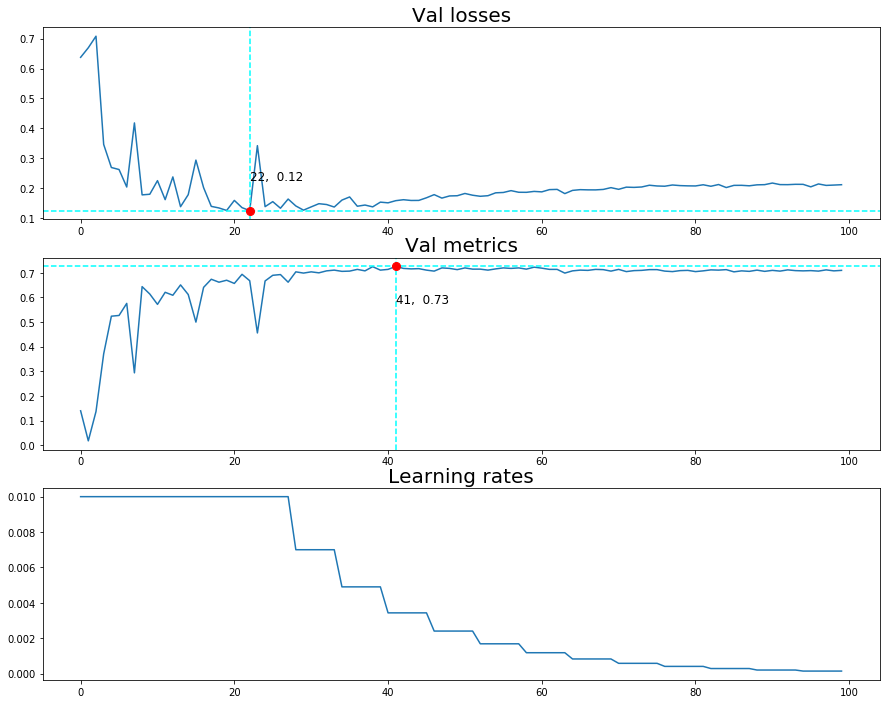

===  experiment 1  ===


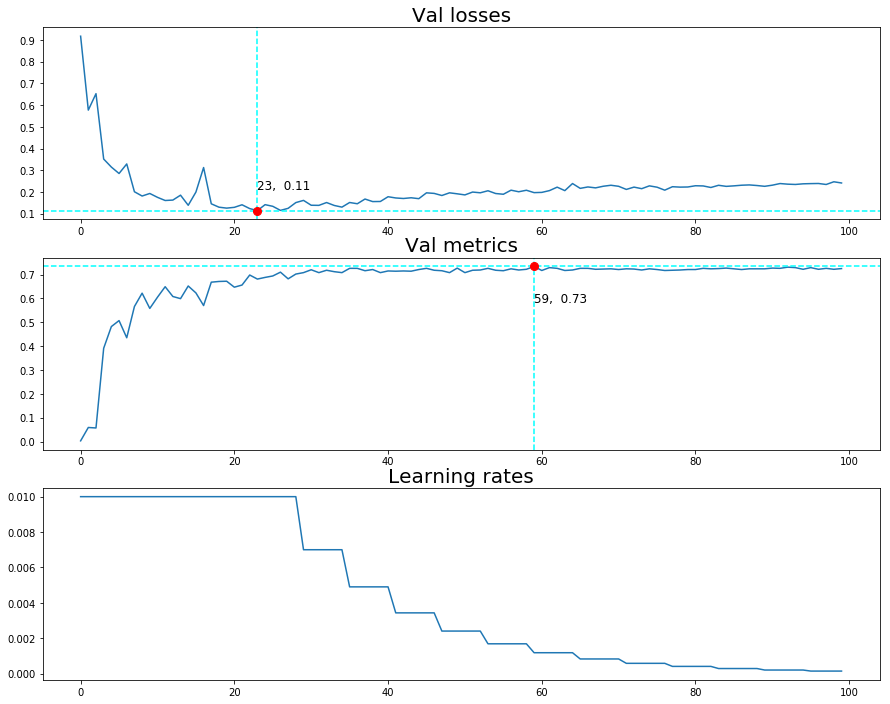

===  experiment 2  ===


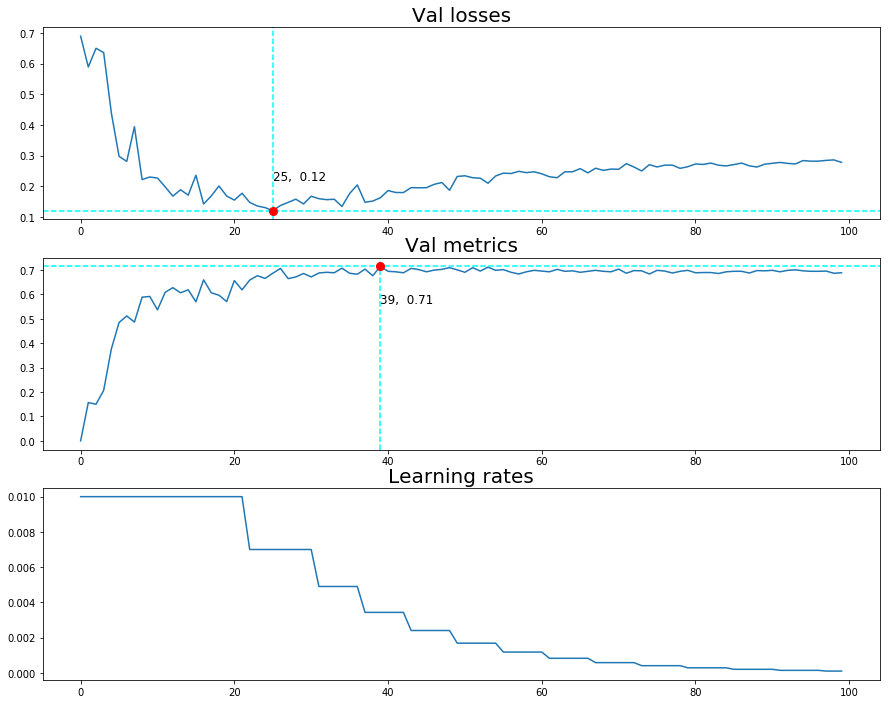

===  experiment 3  ===


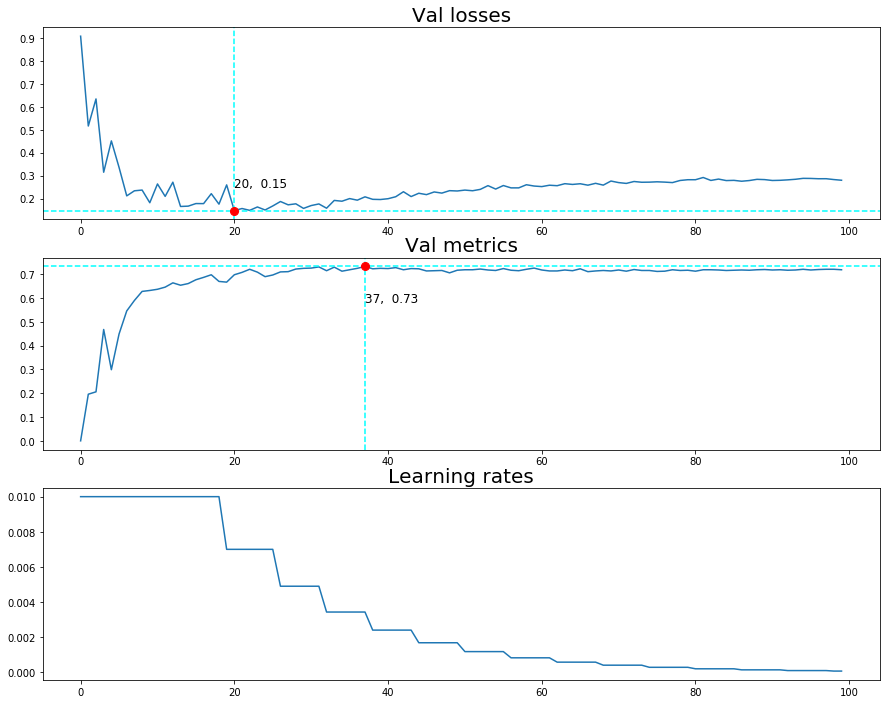

===  experiment 4  ===


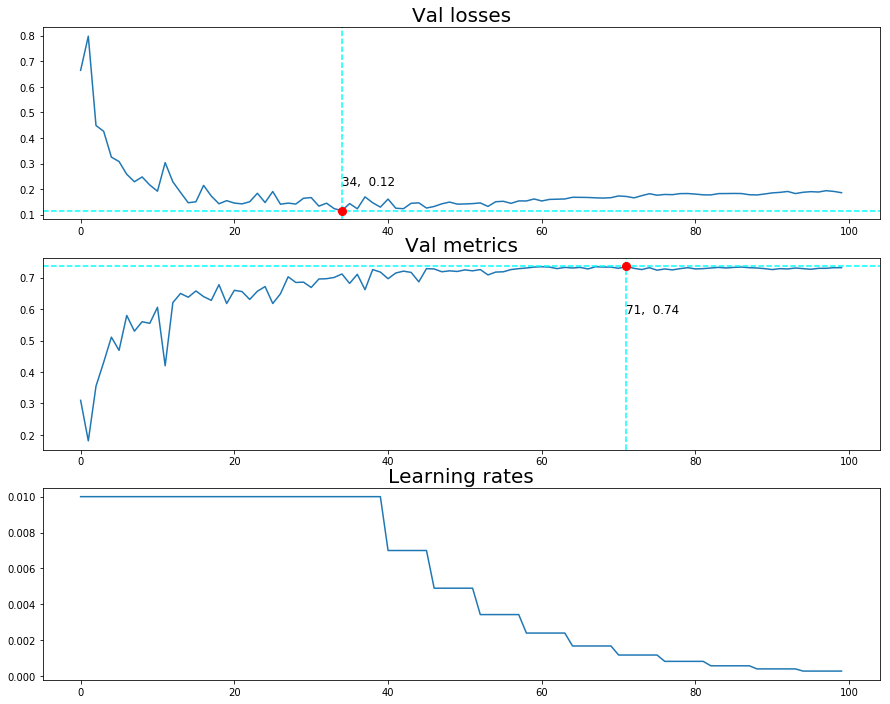

In [7]:
for i in range(n_vals_to_carry):
    print(f'===  experiment {i}  ===')
    plot_metrics(EXP_PATH, n_val=i)

<hr/>